In [256]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tqdm import tqdm_notebook as tqdm
from tcn import TCN
import time
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from keras.preprocessing import sequence
from keras.models import Sequential , load_model , Model
from keras.layers import Dense, Dropout , LSTM , Bidirectional ,GRU ,Flatten,Add,BatchNormalization
from keras_layer_normalization import LayerNormalization
from keras.initializers import  glorot_normal, RandomUniform
from keras import optimizers,Input
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
#data

In [257]:
df = pd.read_csv("station_bike _Craven.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")
#df.head()

df["hour"] = df.index.hour
df["day_of_month"] = df.index.day
df["day_of_week"]  = df.index.dayofweek
df["month"] = df.index.month

training_data_len = math.ceil(len(df) * 0.9) # taking 90% of data to train and 10% of data to test
testing_data_len = len(df) - training_data_len

time_steps = 24
train, test = df.iloc[0:training_data_len], df.iloc[(training_data_len-time_steps):len(df)]
print(df.shape, train.shape, test.shape)

df.head()

(160, 13) (144, 13) (40, 13)


,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,,,,,,
2015-09-06 00:00:00,2,11.0,11.0,72.0,5.0,1,0,1,2,0,6,6,9
2015-09-06 01:00:00,2,10.0,10.0,82.0,6.0,1,0,1,2,1,6,6,9
2015-09-06 02:00:00,0,10.0,10.0,82.0,5.0,1,0,1,2,2,6,6,9
2015-09-06 03:00:00,0,10.0,10.0,79.0,6.0,1,0,1,2,3,6,6,9
2015-09-06 04:00:00,0,9.0,8.0,84.5,8.0,1,0,1,2,4,6,6,9


In [258]:
train_trans = train[['t1','t2', 'hum', 'wind_speed']].to_numpy()
test_trans = test[['t1','t2', 'hum', 'wind_speed']].to_numpy()

scaler = RobustScaler() # Handles outliers
#scaler = MinMaxScaler(feature_range=(0, 1)) # scale to (0,1)
train.loc[:, ['t1','t2','hum', 'wind_speed']]=scaler.fit_transform(train_trans)
test.loc[:, ['t1','t2', 'hum', 'wind_speed']]=scaler.fit_transform(test_trans)

train['cnt'] = scaler.fit_transform(train[['cnt']])
test['cnt'] = scaler.fit_transform(test[['cnt']])

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in tqdm(range(len(train) - time_steps)):
    x_train.append(train.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    y_train.append(train.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

#Create the x_test and y_test data sets
x_test = []
y_test = df.loc[:,'cnt'].iloc[training_data_len:len(df)]

for i in tqdm(range(len(test) - time_steps)):
    x_test.append(test.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    # y_test.append(test.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_test and y_test to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# All 12 columns of the data
print('Train size:')
print(x_train.shape, y_train.shape)
print('Test size:')
print(x_test.shape, y_test.shape)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

  0%|          | 0/120 [00:00<?, ?it/s]

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/16 [00:00<?, ?it/s]

Train size:
(120, 24, 12) (120,)
Test size:
(16, 24, 12) (16,)


In [252]:
from keras.layers import Concatenate
init = glorot_normal(seed=None) # 給 GRU
init_d = RandomUniform(minval=-0.05, maxval=0.05) # 給 Dense layer

def Encoder(layer):
    shortcut = layer
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = Add()([layer,shortcut])
    layer = LayerNormalization()(layer)
    layer = Flatten()(layer)
    
    shortcut2 = layer
    layer = Dense(12,kernel_initializer=init_d)(layer)
    layer = Dropout(0.2)(layer)
    layer = Concatenate()([layer,shortcut2])
    output = Dense(1,kernel_initializer=init_d)(layer)
    return output

def Decoder(layer):
    shortcut = layer
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = Add()([layer,shortcut])
    layer = LayerNormalization()(layer)
    layer = SeqSelfAttention(
                     attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=tf.keras.regularizers.l2(0.01),
                     bias_regularizer=tf.keras.regularizers.l2(0.01),
                     attention_regularizer_weight=0.0001)(layer)
    layer = LayerNormalization()(layer)
    
    layer = Flatten()(layer)
    shortcut2 = layer
    layer = Dense(10,kernel_initializer=init_d)(layer)
    #layer = Dropout(0.2)(layer)
    layer = Concatenate()([layer,shortcut2])
    output = Dense(1,kernel_initializer=init_d)(layer)
    return output

def Bi_GRU(layer,unit):
    output = Bidirectional(GRU(unit, dropout=0.1, recurrent_dropout=0.1, return_sequences=True,
                            kernel_initializer=init))(layer)
    return output

In [253]:
#start = Input(shape = (x_train.shape[1],x_train.shape[2]))
start = Input(shape = (x_train.shape[1:]))
start2 = Input(shape = (x_train.shape[1:]))
x = Bi_GRU(start,12)
x = Encoder(x)

# y = Bi_GRU(start2,8)
# y = Decoder(y)

#Merge = Add()([x,x])
Last = Dense(1)(x)
model = Model([start,start2] , Last)
model.summary()

Model: "model_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_126 (InputLayer)          (None, 24, 12)       0                                            
__________________________________________________________________________________________________
bidirectional_66 (Bidirectional (None, 24, 24)       1800        input_126[0][0]                  
__________________________________________________________________________________________________
seq_self_attention_68 (SeqSelfA (None, 24, 24)       577         bidirectional_66[0][0]           
__________________________________________________________________________________________________
add_86 (Add)                    (None, 24, 24)       0           seq_self_attention_68[0][0]      
                                                                 bidirectional_66[0][0]    

In [254]:
opt = optimizers.Adam(lr=0.001,decay = 0.0001)
print('Train...')
# model.compile(optimizer = opt , loss="mse")
model.compile(optimizer = "adam" , loss="mse")
history = model.fit([x_train,x_train], y_train, epochs = 500, batch_size=8, validation_split=0.1, shuffle=True)
# history = model.fit(x_train, y_train, epochs = 500, batch_size=6, validation_split=0.1, shuffle=True)
model.summary()
#Save Model
model.save('GRU_Single_Attention_model_craven.h5')  # creates a HDF5 file 
del model

Train...
Train on 108 samples, validate on 12 samples
Epoch 1/500
108/108 [==============================] - 2s 14ms/step - loss: 1.1259 - val_loss: 1.0780
Epoch 2/500
108/108 [==============================] - 1s 5ms/step - loss: 0.9472 - val_loss: 0.9182
Epoch 3/500
108/108 [==============================] - 1s 5ms/step - loss: 0.8085 - val_loss: 0.9496
Epoch 4/500
108/108 [==============================] - 1s 5ms/step - loss: 0.7847 - val_loss: 0.9406
Epoch 5/500
108/108 [==============================] - 1s 5ms/step - loss: 0.7707 - val_loss: 0.7906
Epoch 6/500
108/108 [==============================] - 1s 5ms/step - loss: 0.7621 - val_loss: 0.7470
Epoch 7/500
108/108 [==============================] - 1s 5ms/step - loss: 0.7785 - val_loss: 1.2588
Epoch 8/500
108/108 [==============================] - 1s 5ms/step - loss: 0.6678 - val_loss: 0.8809
Epoch 9/500
108/108 [==============================] - 1s 5ms/step - loss: 0.5761 - val_loss: 0.9024
Epoch 10/500
108/108 [==============

Epoch 81/500
108/108 [==============================] - 1s 5ms/step - loss: 0.1965 - val_loss: 0.2547
Epoch 82/500
108/108 [==============================] - 1s 5ms/step - loss: 0.1153 - val_loss: 0.2132
Epoch 83/500
108/108 [==============================] - 1s 5ms/step - loss: 0.1491 - val_loss: 0.2426
Epoch 84/500
108/108 [==============================] - 1s 5ms/step - loss: 0.1431 - val_loss: 0.4427
Epoch 85/500
108/108 [==============================] - 1s 5ms/step - loss: 0.1272 - val_loss: 0.4142
Epoch 86/500
108/108 [==============================] - 1s 5ms/step - loss: 0.1485 - val_loss: 0.2680
Epoch 87/500
108/108 [==============================] - 1s 5ms/step - loss: 0.1280 - val_loss: 0.2334
Epoch 88/500
108/108 [==============================] - 1s 5ms/step - loss: 0.1048 - val_loss: 0.2945
Epoch 89/500
108/108 [==============================] - 1s 5ms/step - loss: 0.1123 - val_loss: 0.3153
Epoch 90/500
108/108 [==============================] - 1s 5ms/step - loss: 0.1223

108/108 [==============================] - 1s 5ms/step - loss: 0.0847 - val_loss: 0.3710
Epoch 240/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0903 - val_loss: 0.3280
Epoch 241/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0755 - val_loss: 0.6610
Epoch 242/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0627 - val_loss: 0.4841
Epoch 243/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0510 - val_loss: 0.3575
Epoch 244/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0579 - val_loss: 0.3856
Epoch 245/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0606 - val_loss: 0.3879
Epoch 246/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0710 - val_loss: 0.3566
Epoch 247/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0723 - val_loss: 0.3444
Epoch 248/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0579 - v

108/108 [==============================] - 1s 5ms/step - loss: 0.0499 - val_loss: 0.4076
Epoch 398/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0343 - val_loss: 0.4136
Epoch 399/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0515 - val_loss: 0.3684
Epoch 400/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0585 - val_loss: 0.4090
Epoch 401/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0858 - val_loss: 0.3692
Epoch 402/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0373 - val_loss: 0.5214
Epoch 403/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0428 - val_loss: 0.5509
Epoch 404/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0314 - val_loss: 0.3856
Epoch 405/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0310 - val_loss: 0.5178
Epoch 406/500
108/108 [==============================] - 1s 5ms/step - loss: 0.0334 - v

Predict time:  0.28623461723327637
RMSE:  17.789416172912805
RMSE2:  11.381855861694348
MAE:  13.167350300720761
MAE2:  13.167350300720761


Text(0, 0.5, 'mse score')

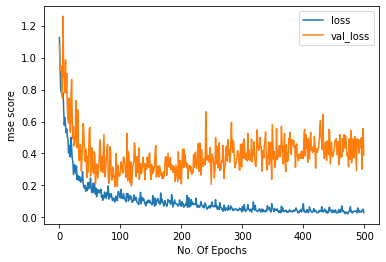

In [255]:
custom_ob = {'LayerNormalization': LayerNormalization , 'SeqSelfAttention':SeqSelfAttention}
model = load_model('GRU_Single_Attention_model_craven.h5', custom_objects=custom_ob)
t1 = time.time()
# y_pred = model.predict([x_test,x_test])
y_pred2 = model.predict(x_test)
y_pred = model.predict(x_train)
t2 = time.time()
print('Predict time: ',t2-t1)
y_pred = scaler.inverse_transform(y_pred)#Undo scaling
rmse_lstm2 = np.sqrt(mean_squared_error(y_test, y_pred2))
rmse_lstm = np.sqrt(mean_squared_error(y_train, y_pred))
print('RMSE: ',rmse_lstm)
print('RMSE2: ',rmse_lstm2)
mae = mean_absolute_error(y_test, y_pred2)
mae = mean_absolute_error(y_train, y_pred)
print('MAE: ',mae)
print('MAE2: ',mae)
# r22 =  r2_score(y_test, y_pred2)
# r2 =  r2_score(y_train, y_pred)
# print('R-square: ',r2)
# print('R-square2: ',r22)

# n = len(y_test)
# p = 12
# Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
# Adj_r22 = 1-(1-r22)*(n-1)/(n-p-1)
# print('Adj R-square: ',Adj_r2)
# print('Adj R-square2: ',Adj_r22)

plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

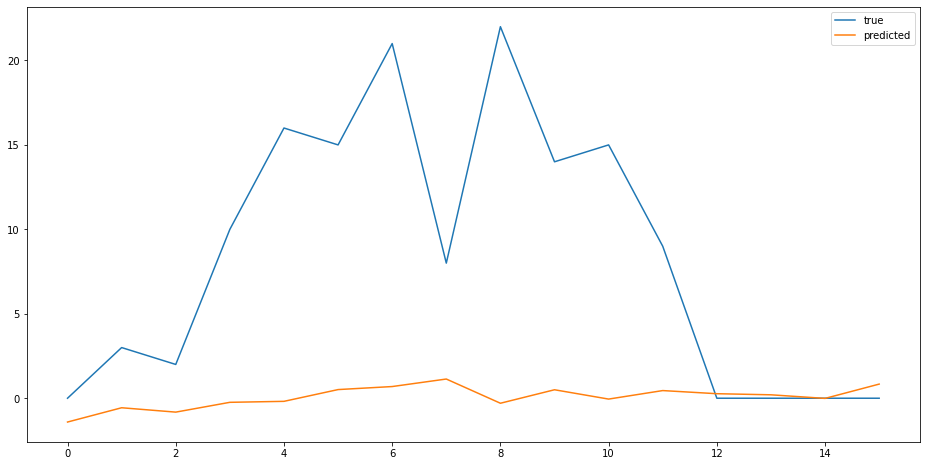

In [207]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='true')
# plt.plot(y_train, label='true')
plt.plot(y_pred2, label='predicted')
plt.legend()

Train on 108 samples, validate on 12 samples
Epoch 1/200
108/108 [==============================] - 3s 28ms/step - loss: 1.6408 - val_loss: 1.6923
Epoch 2/200
108/108 [==============================] - 1s 6ms/step - loss: 1.5737 - val_loss: 1.6390
Epoch 3/200
108/108 [==============================] - 1s 6ms/step - loss: 1.5047 - val_loss: 1.5836
Epoch 4/200
108/108 [==============================] - 1s 6ms/step - loss: 1.4477 - val_loss: 1.5316
Epoch 5/200
108/108 [==============================] - 1s 6ms/step - loss: 1.4072 - val_loss: 1.4870
Epoch 6/200
108/108 [==============================] - 1s 6ms/step - loss: 1.3605 - val_loss: 1.4437
Epoch 7/200
108/108 [==============================] - 1s 6ms/step - loss: 1.3013 - val_loss: 1.4023
Epoch 8/200
108/108 [==============================] - 1s 6ms/step - loss: 1.2594 - val_loss: 1.3674
Epoch 9/200
108/108 [==============================] - 1s 6ms/step - loss: 1.2175 - val_loss: 1.3338
Epoch 10/200
108/108 [=======================

Epoch 81/200
108/108 [==============================] - 1s 6ms/step - loss: 0.5685 - val_loss: 0.7678
Epoch 82/200
108/108 [==============================] - 1s 6ms/step - loss: 0.5553 - val_loss: 0.7309
Epoch 83/200
108/108 [==============================] - 1s 6ms/step - loss: 0.5835 - val_loss: 0.7269
Epoch 84/200
108/108 [==============================] - 1s 6ms/step - loss: 0.5949 - val_loss: 0.7179
Epoch 85/200
108/108 [==============================] - 1s 6ms/step - loss: 0.5572 - val_loss: 0.7391
Epoch 86/200
108/108 [==============================] - 1s 6ms/step - loss: 0.5552 - val_loss: 0.7446
Epoch 87/200
108/108 [==============================] - 1s 6ms/step - loss: 0.5252 - val_loss: 0.7452
Epoch 88/200
108/108 [==============================] - 1s 6ms/step - loss: 0.5794 - val_loss: 0.7451
Epoch 89/200
108/108 [==============================] - 1s 6ms/step - loss: 0.5525 - val_loss: 0.7409
Epoch 90/200
108/108 [==============================] - 1s 6ms/step - loss: 0.5440

Text(0, 0.5, 'mse score')

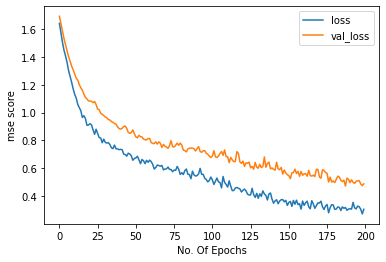

In [261]:
from keras import regularizers
init = glorot_normal(seed=None) # 給 LSTM
init_d = RandomUniform(minval=-0.05, maxval=0.05) # 給 Dense layer
nadam = optimizers.Nadam(lr=0.0015,clipvalue=0.5)

model = Sequential()
model.add(Bidirectional(GRU(6, kernel_initializer=init ,return_sequences = True,kernel_regularizer=regularizers.l2(0.01)
                             ,recurrent_regularizer = regularizers.l2(0.01) ,input_shape=(x_train.shape[1],x_train.shape[2]))))
model.add(LayerNormalization())
model.add(Bidirectional(GRU(6,kernel_initializer=init,kernel_regularizer=regularizers.l2(0.01),recurrent_regularizer = regularizers.l2(0.01))))
model.add(Dropout(0.25))
model.add(Dense(units=1, kernel_initializer=init_d))
model.compile(optimizer = nadam , loss="mse")
history = model.fit(x_train, y_train, epochs=200, batch_size=24, validation_split=0.1, shuffle=True)
#model summary
model.summary()
#Save Model
model.save('GRU_model_craven.h5')  # creates a HDF5 file 
print('Model Saved')
del model  # deletes the existing model

custom_ob = {'LayerNormalization': LayerNormalization , 'SeqSelfAttention':SeqSelfAttention}
model = load_model('GRU_model_craven.h5', custom_objects=custom_ob)
t1 = time.time()
# y_pred = model.predict([x_test,x_test])
y_pred2 = model.predict(x_test)
y_pred = model.predict(x_train)
t2 = time.time()
print('Predict time: ',t2-t1)
y_pred = scaler.inverse_transform(y_pred)#Undo scaling
rmse_lstm2 = np.sqrt(mean_squared_error(y_test, y_pred2))
rmse_lstm = np.sqrt(mean_squared_error(y_train, y_pred))
print('RMSE: ',rmse_lstm)
print('RMSE2: ',rmse_lstm2)
mae = mean_absolute_error(y_test, y_pred2)
mae = mean_absolute_error(y_train, y_pred)
print('MAE: ',mae)
print('MAE2: ',mae)
# r22 =  r2_score(y_test, y_pred2)
# r2 =  r2_score(y_train, y_pred)
# print('R-square: ',r2)
# print('R-square2: ',r22)

# n = len(y_test)
# p = 12
# Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
# Adj_r22 = 1-(1-r22)*(n-1)/(n-p-1)
# print('Adj R-square: ',Adj_r2)
# print('Adj R-square2: ',Adj_r22)

plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")